
<image src="https://github.com/semilleroCV/Hands-on-Computer-Vision/blob/2024/Sesiones/Sesion5/Parte%201/images/cover-page.png?raw=true" width=100%>



# <center> **04. Estimación pasiva de la profundidad** </center>

La estimación pasiva de la profundidad es el conjunto de técnicas y algoritmos para estimar la distancia observada de objetos para permitir una comprensión tridimensional (3D) del entorno circundante. Durante esta sesión vamos a aplicar los conceptos explicados, **para estimar la disparidad en imágenes estéreo prediseñadas mediante diversas técnicas de programación y así obtener los mapas de disparidad y profundidad.**

In [1]:
# @title **Instalamos Paquetes necesarios**
!pip install --upgrade timm -q

import os
import cv2
import torch
import pandas
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import (
    AutoImageProcessor,
    AutoModelForDepthEstimation,
    ZoeDepthForDepthEstimation,
)


# Descargar imágenes si no existen
if not os.path.exists("/content/28.png"):
    !wget -O /content/28.png https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/28.png

if not os.path.exists("/content/color.png"):
    !wget -O /content/color.png https://raw.githubusercontent.com/semilleroCV/Hands-on-Computer-Vision/f0142bf70526f90218f13836038e94cca4d94e7d/sesiones/sesion5/color.png

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/664.8 MB 2.9 MB/s eta 0:02:23
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.3 MB/s eta 0:00:00
ERROR: THESE PACKAGES DO NOT MATCH THE HASHES FROM THE REQUIREMENTS FILE. If you have updated the package versions, please update the hashes. Otherwise, examine the package contents carefully; someone m

In [2]:
# @title prerequisitos

def plot_depth(depth, title=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    img = ax.imshow(np.array(depth), cmap="inferno")
    ax.axis("off")
    if title:
        ax.set_title(title)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(img, cax=cax).set_label("Depth")
    plt.tight_layout()
    plt.show()


def normalize_depth(depth):
    depth_np = np.array(depth)
    depth_min, depth_max = depth_np.min(), depth_np.max()
    if depth_max - depth_min == 0:
        return np.zeros_like(depth_np)
    return (depth_np - depth_min) / (depth_max - depth_min)


def get_line(predicted_image, true_depth_image):
    x = predicted_image.flatten()
    y = true_depth_image.flatten()

    # Filtrar valores válidos (ni NaN ni Inf)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    if len(x) < 2:
        return None, None, None, None  # No hay suficientes puntos válidos

    try:
        a, b = np.polyfit(x, y, 1)
        return a, b, x, y
    except Exception as e:
        print(f"Error al ajustar línea: {e}")
        return None, None, None, None


def compute_scale_and_shift(prediction, target):
    """
    Compute scale and shift to align the 'prediction' to the 'target' using the 'mask'.

    This function solves the system Ax = b to find the scale (x_0) and shift (x_1) that aligns the prediction to the target.
    The system matrix A and the right hand side b are computed from the prediction, target, and mask.

    Args:
        prediction (torch.Tensor): Predicted values.
        target (torch.Tensor): Ground truth values.
        mask (torch.Tensor): Mask that indicates the zones to evaluate.

    Returns:
        tuple: Tuple containing the following:
            x_0 (torch.Tensor): Scale factor to align the prediction to the target.
            x_1 (torch.Tensor): Shift to align the prediction to the target.
    """
    # system matrix: A = [[a_00, a_01], [a_10, a_11]]
    a_00 = torch.sum(prediction * prediction, (1, 2))
    a_01 = torch.sum(prediction, (1, 2))
    a_11 = torch.sum(torch.ones_like(prediction), (1, 2))

    # right hand side: b = [b_0, b_1]
    b_0 = torch.sum(prediction * target, (1, 2))
    b_1 = torch.sum(target, (1, 2))

    # solution: x = A^-1 . b = [[a_11, -a_01], [-a_10, a_00]] / (a_00 * a_11 - a_01 * a_10) . b
    x_0 = torch.zeros_like(b_0)
    x_1 = torch.zeros_like(b_1)

    det = a_00 * a_11 - a_01 * a_01
    # A needs to be a positive definite matrix.
    valid = det > 0

    x_0[valid] = (a_11[valid] * b_0[valid] - a_01[valid] * b_1[valid]) / det[valid]
    x_1[valid] = (-a_01[valid] * b_0[valid] + a_00[valid] * b_1[valid]) / det[valid]

    return x_0, x_1


def compute_scale_and_shift_numpy(prediction, target):
    pred = torch.from_numpy(prediction).unsqueeze(0)
    tgt = torch.from_numpy(target).unsqueeze(0)

    x_0, x_1 = compute_scale_and_shift(pred, tgt)
    aligned = x_0[0].item() * pred[0] + x_1[0].item()

    return aligned.numpy()


## <font color='#4C5FDA'>**1. Estimación monocular de la profundidad**</font> <a name="tema1">




### <font color="EB9A54"> **1.1:** </font> Probemos modelos fundacionales de estimación monocular

## **Inferencia**

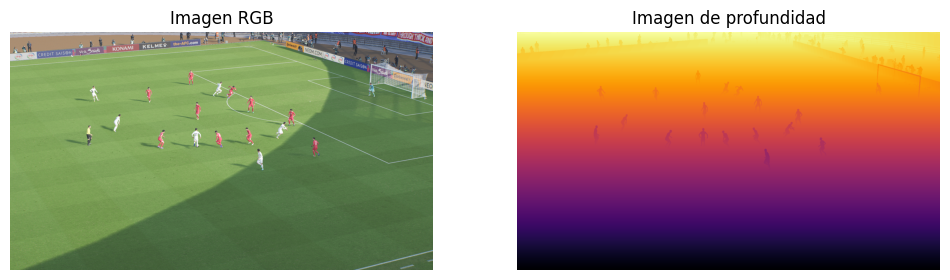

In [3]:
# @title **Cargamos la imagen RGB y la profundidad**
# Ruta de la imagen
rgb = "./color.png"

# Carga la imagen
image = Image.open(rgb).convert("RGB")

# Cargamos el gt
depth = "./28.png"
# Carga la imagen
depth_image = Image.open(depth)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image)
ax[0].set_title("Imagen RGB")
ax[0].axis("off")
ax[1].imshow(depth_image, cmap="inferno")
ax[1].set_title("Imagen de profundidad")
ax[1].axis("off")
plt.show()


# Modelos de predicción de profundidad

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json:   0%|          | 0.00/2.23k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

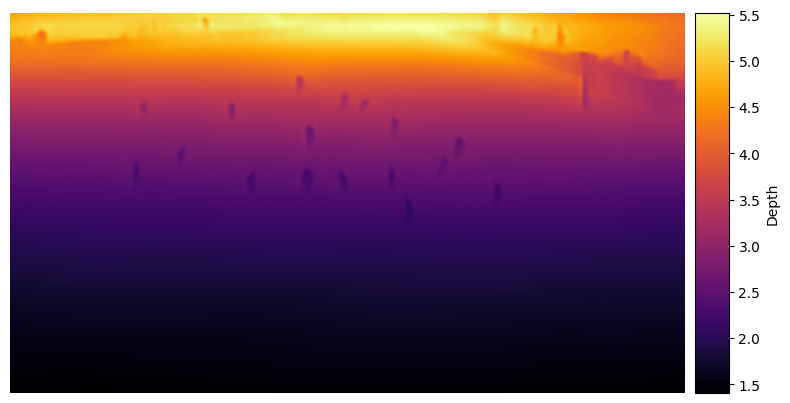

In [4]:
# @title **ZeoDepth**
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

image_processor = AutoImageProcessor.from_pretrained("Intel/zoedepth-nyu-kitti")
model = ZoeDepthForDepthEstimation.from_pretrained("Intel/zoedepth-nyu-kitti")

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    source_sizes=[(image.height, image.width)],
)

predicted_depth_zoedepth = post_processed_output[0]["predicted_depth"]

plot_depth(predicted_depth_zoedepth)

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

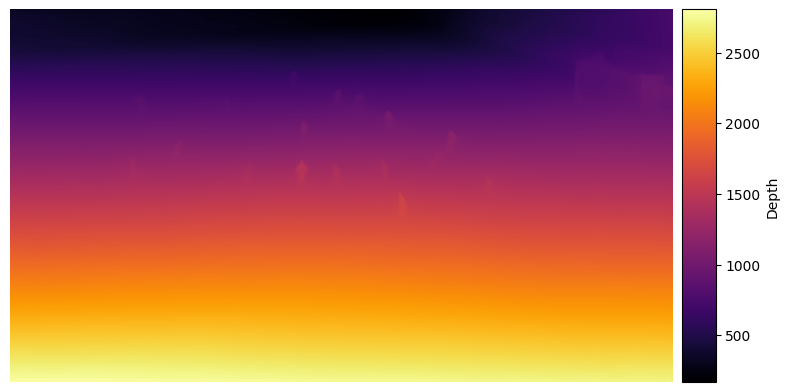

In [5]:
# @title **MiDaS**
model_type = "DPT_Hybrid"

midas = torch.hub.load("intel-isl/MiDaS", model_type)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

img = cv2.imread(rgb)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

with torch.no_grad():
    depth_midas = midas(input_batch)

    depth_midas = torch.nn.functional.interpolate(
        depth_midas.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

depth_midas = depth_midas.cpu().numpy()
plot_depth(depth_midas)

preprocessor_config.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/954 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

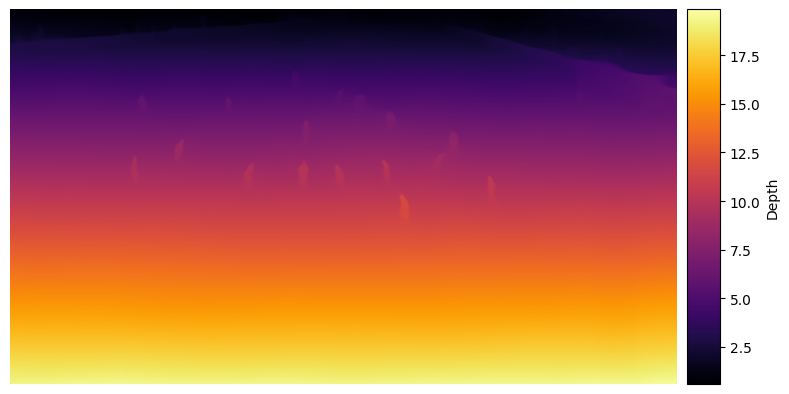

In [6]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

image_processor = AutoImageProcessor.from_pretrained(
    "LiheYoung/depth-anything-small-hf"
)
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

predicted_depth_da1 = post_processed_output[0]["predicted_depth"]

plot_depth(predicted_depth_da1)


preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

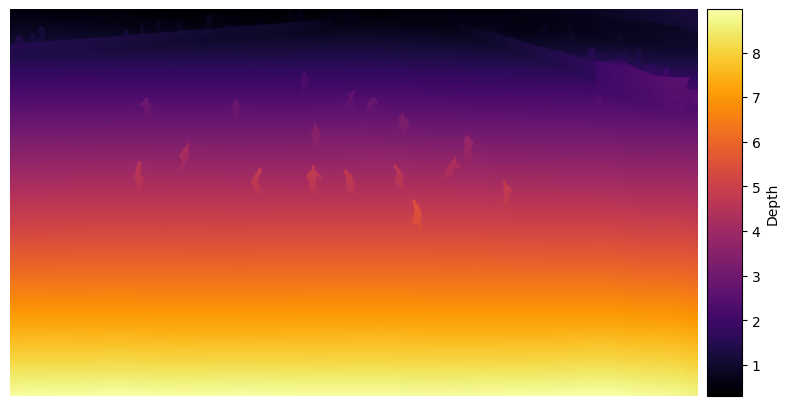

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

image_processor = AutoImageProcessor.from_pretrained(
    "depth-anything/Depth-Anything-V2-Small-hf"
)
model = AutoModelForDepthEstimation.from_pretrained(
    "depth-anything/Depth-Anything-V2-Small-hf"
)

inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

predicted_depth_da2 = post_processed_output[0]["predicted_depth"]

plot_depth(predicted_depth_da2)


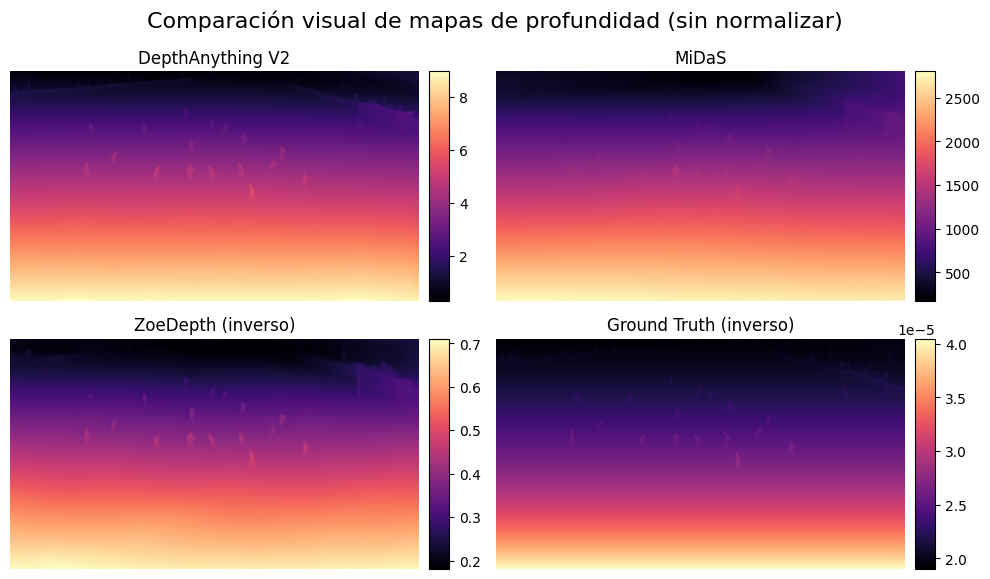

In [8]:
# Cargar y procesar ground truth
true_depth = 1.0 / (
    cv2.imread("28.png", cv2.IMREAD_UNCHANGED).astype(np.float32) + 1e-6
)


# Función para redimensionar mapas de profundidad
def resize(d):
    return cv2.resize(
        np.array(d),
        (true_depth.shape[1], true_depth.shape[0]),
        interpolation=cv2.INTER_CUBIC,
    )


# Redimensionar mapas
depth_maps = [
    resize(predicted_depth_da2),
    resize(depth_midas),
    1.0 / resize(predicted_depth_zoedepth),
    true_depth,
]
titles = ["DepthAnything V2", "MiDaS", "ZoeDepth (inverso)", "Ground Truth (inverso)"]

# Graficar
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
for ax, title, depth in zip(axes.flat, titles, depth_maps):
    im = ax.imshow(depth, cmap="magma")
    make_axes_locatable(ax).append_axes("right", size="5%", pad=0.1).figure.colorbar(
        im, cax=plt.gca()
    )
    ax.set_title(title)
    ax.axis("off")

plt.suptitle("Comparación visual de mapas de profundidad (sin normalizar)", fontsize=16)
plt.tight_layout()
plt.show()


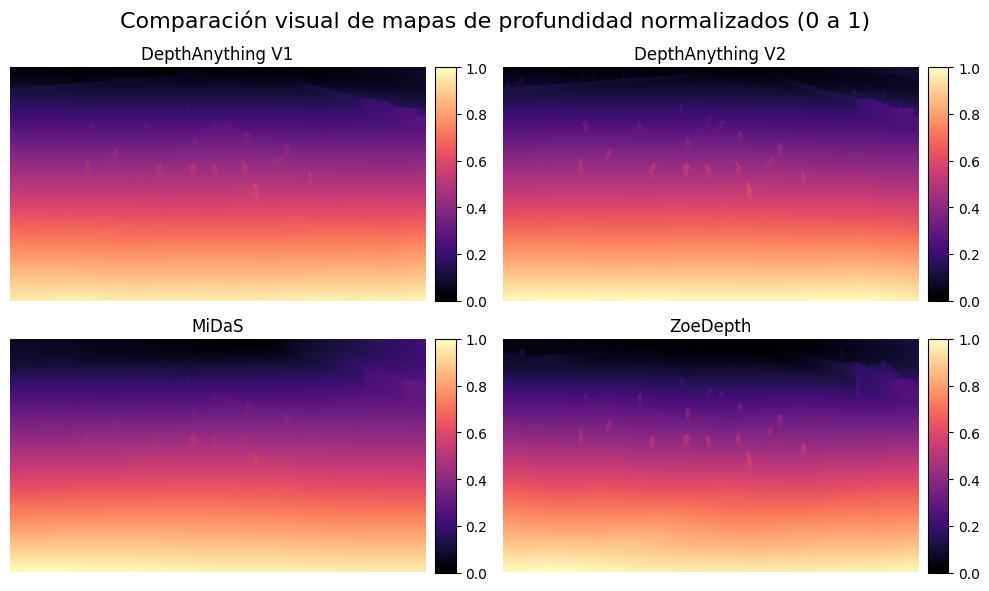

In [9]:
# Redimensionar y normalizar predicciones
depth_dav1_resized = normalize_depth(resize(predicted_depth_da1))
depth_dav2_resized = normalize_depth(resize(predicted_depth_da2))
depth_midas_resized = normalize_depth(resize(depth_midas))
depth_zoe_resized = normalize_depth(1.0 / resize(predicted_depth_zoedepth))
true_depth_norm = normalize_depth(true_depth)

# Preparar plots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
titles = ["DepthAnything V1", "DepthAnything V2", "MiDaS", "ZoeDepth"]
depth_maps = [
    depth_dav1_resized,
    depth_dav2_resized,
    depth_midas_resized,
    depth_zoe_resized,
]

for ax, title, depth_map in zip(axes.flat, titles, depth_maps):
    im = ax.imshow(depth_map, cmap="magma")
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(im, cax=cax, fraction=0.046, pad=0.04)

# Ocultar subplots sobrantes
for ax in axes.flat[len(titles) :]:
    ax.axis("off")

plt.suptitle(
    "Comparación visual de mapas de profundidad normalizados (0 a 1)", fontsize=16
)
plt.tight_layout()
plt.show()


<ipython-input-10-15dcc55ce889>:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


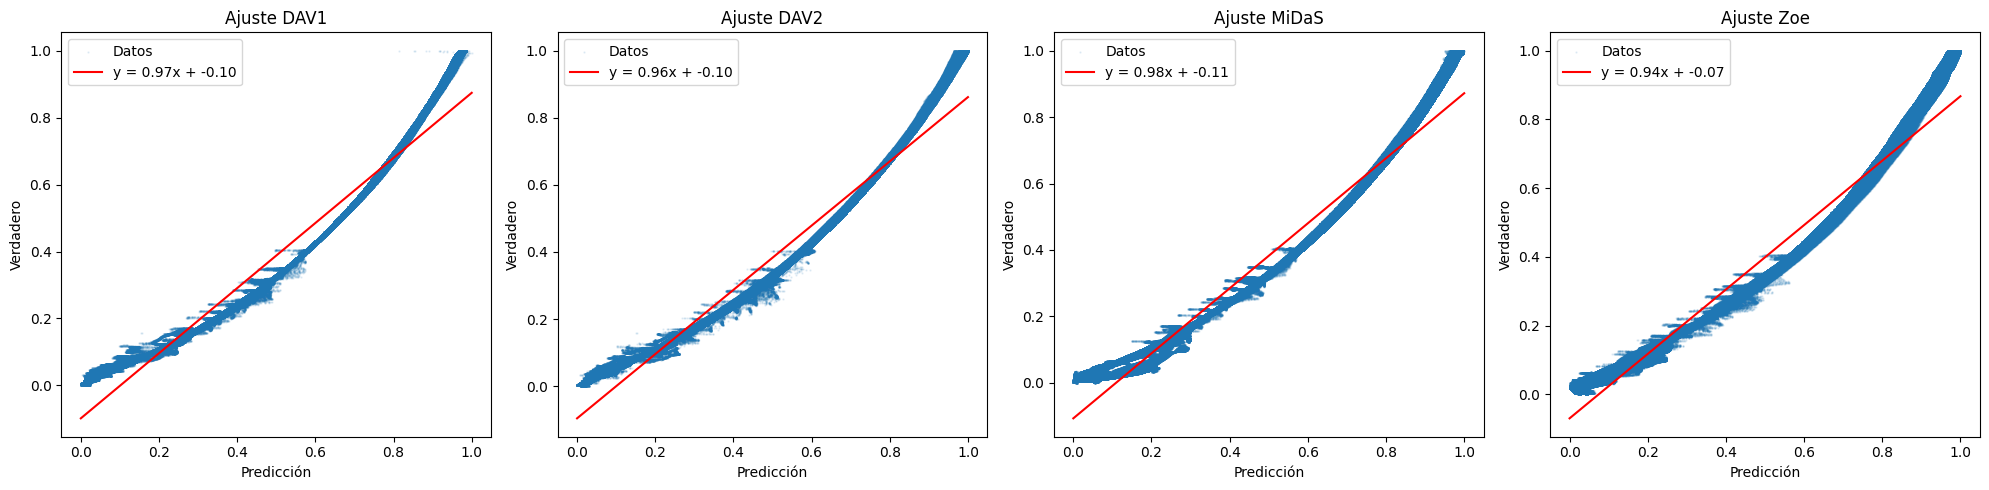

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Listas de mapas y etiquetas
depth_maps = [
    depth_dav1_resized,
    depth_dav2_resized,
    depth_midas_resized,
    depth_zoe_resized,
]

labels = ["DAV1", "DAV2", "MiDaS", "Zoe"]

true_depth = true_depth_norm

# Crear figura
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (depth, label) in enumerate(zip(depth_maps, labels)):
    a, b, x, y = get_line(depth, true_depth)

    if a is None:
        axes[i].set_title(f"{label} (ajuste fallido)")
        continue

    axes[i].scatter(x, y, alpha=0.1, s=0.5, label="Datos")
    x_line = np.linspace(0, 1, 100)
    y_line = a * x_line + b
    axes[i].plot(x_line, y_line, color="red", label=f"y = {a:.2f}x + {b:.2f}")
    axes[i].set_title(f"Ajuste {label}")
    axes[i].set_xlabel("Predicción")
    axes[i].set_ylabel("Verdadero")
    axes[i].legend()

plt.tight_layout()
plt.show()
